<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07C_XTN%20-%20Text%20Classification%20Deep%20Learning%20Sequential%20Models%20Bidirectional%20GRUs%20with%20Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk

nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Load and View Dataset

In [ ]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
## Start from this Cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import re
from pandas import read_excel
dataset=pd.read_csv('/content/drive/MyDrive/Ahsan Thesis/Hate speech/Hate speech/dataset.csv')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# take a peek at the data
dataset.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [ ]:
dataset.describe()

,id
count,6420.000000
mean,3210.500000
std,1853.438696
min,1.000000
25%,1605.750000
50%,3210.500000
75%,4815.250000
max,6420.000000


In [ ]:
# build train and test datasets
reviews = dataset['tweet'].values
sentiments = dataset['label'].values

train_reviews = reviews[:5136]
train_sentiments = sentiments[:5136]

test_reviews = reviews[5136:]
test_sentiments = sentiments[5136:]

# Basic Data Pre-processing

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()
    norm_docs.append(doc)

  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

  0%|          | 0/5136 [00:00<?, ?it/s]<ipython-input-10-b191aaff2e9c>:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
100%|██████████| 1284/1284 [00:00<00:00, 8212.98it/s]

CPU times: user 1.06 s, sys: 0 ns, total: 1.06 s
Wall time: 1.61 s


## Data Preprocessing and formatting

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [ ]:
import keras

t = keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('httpstcokoongoypo5', 17827), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=17828
Number of Documents=5136


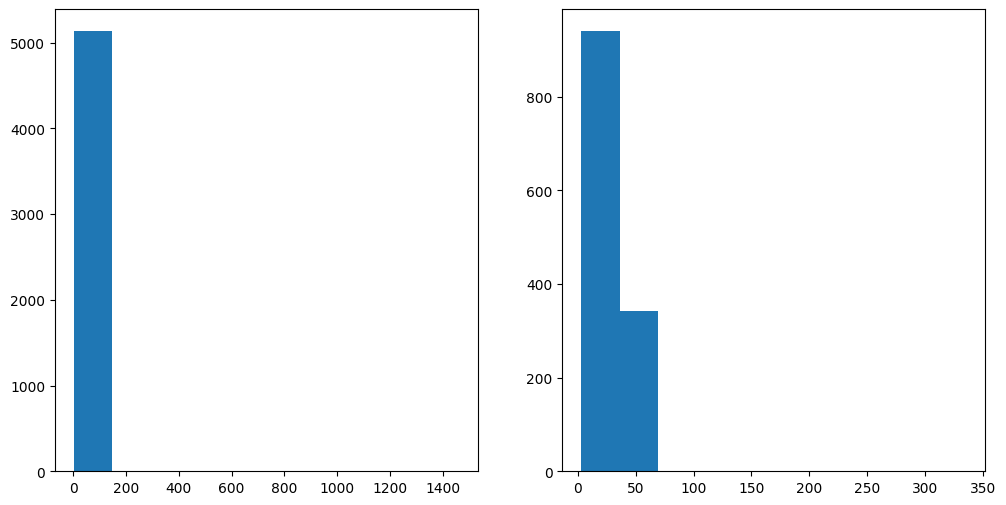

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((5136, 1000), (1284, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

# Bi-directional GRU + Attention Model

## Build Model Architecture

### Attention Layer

Attention Layer focuses on attending to the most important words. We sent all the states from our GRU model into the attention model.

![](https://i.imgur.com/vbGl6Vl.png)

The attention layer produces a context vector

![](https://i.imgur.com/nZ71MVd.png)

![](https://i.imgur.com/00KyS2e.png)

In [ ]:
import tensorflow
tensorflow.__version__

'2.13.0'

In [ ]:
from tensorflow.keras.layers import Layer, InputSpec
from keras import backend as K


class AttentionLayer(Layer):

    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """

        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True


    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None


    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W)
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)


    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Bi-directional GRUs

![](https://i.imgur.com/PuTHi2C.png)

![](https://i.imgur.com/ewTg3gB.png)

![](https://i.imgur.com/oaBYGeu.png)

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import CuDNNLSTM

EMBEDDING_DIM = 100
GRU_DIM = 128
MAX_SEQUENCE_LENGTH = 100  # Define your MAX_SEQUENCE_LENGTH and VOCAB_SIZE accordingly

# Define your input layer
inp = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))

# Embedding layer
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)

# Bidirectional CuDNNLSTM layer
x = tf.keras.layers.Bidirectional(CuDNNLSTM(GRU_DIM, return_sequences=True))(x)

# Attention layer (assuming you have defined this)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)

# Dense layers
x = tf.keras.layers.Dense(GRU_DIM * 2, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.2)(x)

# Output layer
outp = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Initialize the model
model = tf.keras.models.Model(inputs=inp, outputs=outp)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Print model summary
model.summary()


ImportError: ignored

In [ ]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
GRU_DIM = 100 # total LSTM units
tf.compat.v1.keras.layers.CuDNNLSTM
inp = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.LSTM(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
#model = multi_gpu_model(model, gpus=2)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding_7 (Embedding)     (None, 1000, 300)         5348400   
                                                                 
 bidirectional_1 (Bidirecti  (None, 1000, 200)         320800    
 onal)                                                           
                                                                 
 attention_layer_1 (Attenti  (None, 200)               1200      
 onLayer)                                                        
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0   

## Train Model

In [ ]:
batch_size = 32
model.fit(X_train, y_train, epochs=10, batch_size=batch_size,
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
145/145 [==============================] - 32s 186ms/step - loss: 0.6937 - accuracy: 0.5071 - val_loss: 0.6909 - val_accuracy: 0.5292
Epoch 2/10
145/145 [==============================] - 18s 125ms/step - loss: 0.5241 - accuracy: 0.7386 - val_loss: 0.3037 - val_accuracy: 0.8852
Epoch 3/10
145/145 [==============================] - 15s 103ms/step - loss: 0.2076 - accuracy: 0.9282 - val_loss: 0.2331 - val_accuracy: 0.9047
Epoch 4/10
145/145 [==============================] - 14s 99ms/step - loss: 0.0797 - accuracy: 0.9719 - val_loss: 0.2347 - val_accuracy: 0.9241
Epoch 5/10
145/145 [==============================] - 13s 89ms/step - loss: 0.0393 - accuracy: 0.9881 - val_loss: 0.1886 - val_accuracy: 0.9261
Epoch 6/10
145/145 [==============================] - 14s 98ms/step - loss: 0.0097 - accuracy: 0.9963 - val_loss: 0.4122 - val_accuracy: 0.9183
Epoch 7/10
145/145 [==============================] - 14s 95ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.3705 - val_accura

## Evaluate Model Performance

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

41/41 [==============================] - 1s 32ms/step - loss: 0.6492 - accuracy: 0.9182
Accuracy: 91.82%


In [ ]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]


41/41 [==============================] - 2s 31ms/step


In [ ]:
predictions = ['real' if item == 1 else 'fake' for item in predictions]
predictions[:10]

['real',
 'real',
 'fake',
 'real',
 'real',
 'fake',
 'fake',
 'fake',
 'real',
 'real']

In [ ]:
labels = ['real', 'fake']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

        fake       0.89      0.94      0.92       623
        real       0.94      0.89      0.92       661

    accuracy                           0.92      1284
   macro avg       0.92      0.92      0.92      1284
weighted avg       0.92      0.92      0.92      1284



,real,fake
real,588,35
fake,70,591


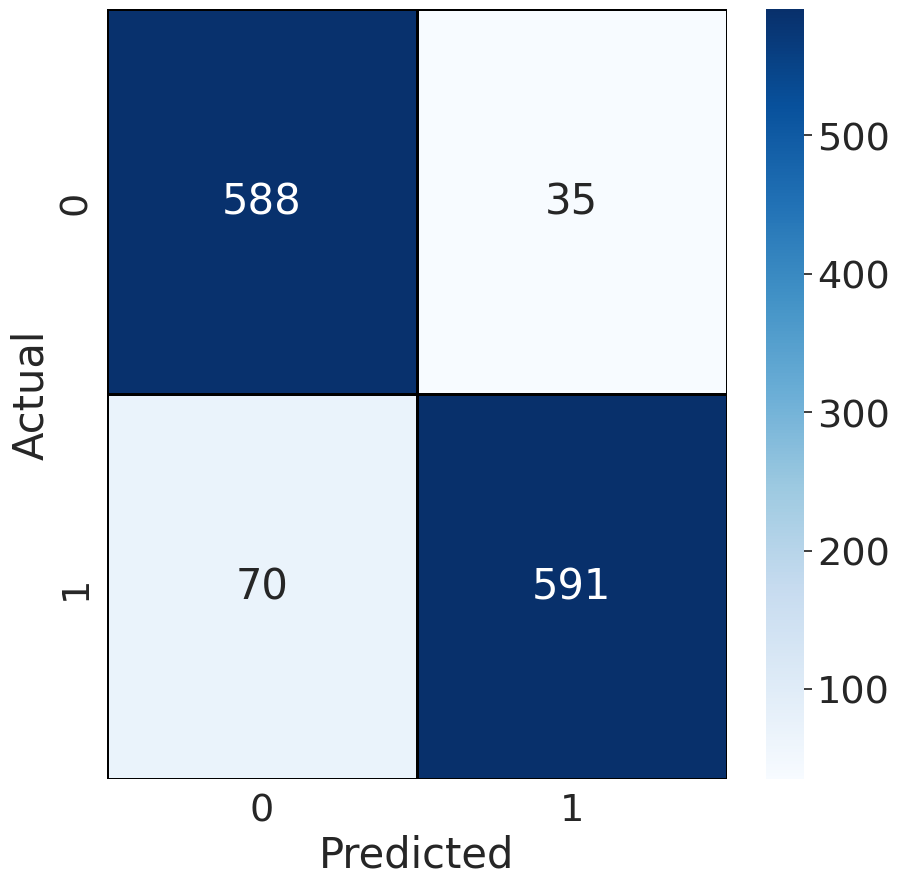

In [ ]:
import seaborn as sn
from sklearn import metrics
cm = metrics.confusion_matrix(test_sentiments, predictions)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues",
            linecolor = 'black',
            linewidth = 1,
            annot = True,
            fmt='',
            )
plt.xlabel("Predicted")
sn.set(font_scale=2.5)

plt.ylabel("Actual")
cm = metrics.confusion_matrix(test_sentiments, predictions)
sn.set(font_scale=2.5)